This Colab notebook demonstrates how to run our workflow using Bayesian Optimization on an example molecular dynamics dataset.

# Download and import

In [ ]:
#@title Download Data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
import os
os.chdir('/content/drive/My Drive/BorosilicateGlassesPotentialOptimization')

In [ ]:
import utils
from utils.data_process import data_process_NNW, load_data, normalize_NNW_data, data_process_bayes, bayes_search_space,store_optimization_results
from utils.model import create_model, train_model, VerboseCallback

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import tqdm
import copy
import csv
import re
import pytz
from datetime import datetime

from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

#Training

Train the MLP model with example MD dataset and store the trained model

## Data Process

In [ ]:
#parameters
data_path = '/content/drive/My Drive/BorosilicateGlassesPotentialOptimization/data/MD_Dataset.xlsx'
new_weight_path = '/content/drive/My Drive/BorosilicateGlassesPotentialOptimization/model/BO_model_weight.pth' #Path to store the trained model
new_normalized_value_path = '/content/drive/My Drive/BorosilicateGlassesPotentialOptimization/model/BO_Normalized_value.pth' #path to store the normalized value for current dataset

batch_size = 64
learning_rate = 5e-4
patience = 100 #50
factor = 0.95
n_epochs = 2000
log_interval = 50

percentage_ranges = [(-10, 10), (-5, 10), (-10, 10), (-10, 10), (-10, 10)] #search range for each parameter
boron_num = np.array([6, 12, 24, 37, 50, 62, 75]) / 100

In [ ]:
# read raw_data
#x: 5 parameter + B2O3 fraction

raw_data_df = load_data(data_path)
x_num, y_num = data_process_NNW(raw_data_df, remove_nan_row = True)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_num, y_num, test_size=0.2, random_state=42)
x_train_norm, x_test_norm, y_train_norm, y_test_norm, normalize_values = normalize_NNW_data(x_train, x_test, y_train, y_test)

In [ ]:
# Create TensorDatasets
train_dataset = TensorDataset(x_train_norm, y_train_norm)
test_dataset = TensorDataset(x_test_norm, y_test_norm)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model training

predict density and B4 through the MLP from parameter and B2O3 fraction

In [ ]:
# Create and train model
model = create_model()
print(model)

Sequential(
  (0): Linear(in_features=6, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=16, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
best_model_weights, best_mse, history = train_model(model, train_loader, test_loader,n_epochs, learning_rate, patience = patience, factor = factor)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 49, Train MSE: 0.0095, Test MSE: 0.0079, LR: 5.00e-04
Epoch: 99, Train MSE: 0.0061, Test MSE: 0.0051, LR: 5.00e-04
Epoch: 149, Train MSE: 0.0045, Test MSE: 0.0040, LR: 5.00e-04
Epoch: 199, Train MSE: 0.0036, Test MSE: 0.0034, LR: 5.00e-04
Epoch: 249, Train MSE: 0.0023, Test MSE: 0.0032, LR: 5.00e-04
Epoch: 299, Train MSE: 0.0018, Test MSE: 0.0025, LR: 5.00e-04
Epoch: 349, Train MSE: 0.0016, Test MSE: 0.0023, LR: 5.00e-04
Epoch: 399, Train MSE: 0.0013, Test MSE: 0.0024, LR: 5.00e-04
Epoch: 449, Train MSE: 0.0013, Test MSE: 0.0023, LR: 5.00e-04
Epoch: 499, Train MSE: 0.0013, Test MSE: 0.0026, LR: 5.00e-04
Epoch: 549, Train MSE: 0.0012, Test MSE: 0.0022, LR: 5.00e-04
Epoch: 599, Train MSE: 0.0011, Test MSE: 0.0021, LR: 5.00e-04
Epoch: 649, Train MSE: 0.0010, Test MSE: 0.0022, LR: 5.00e-04
Epoch: 699, Train MSE: 0.0009, Test MSE: 0.0019, LR: 5.00e-04
Epoch: 749, Train MSE: 0.0009, Test MSE: 0.0020, LR: 5.00e-04
Epoch: 799, Train MSE: 0.0009, Test MSE: 0.0019, LR: 5.00e-04
Epoch: 849

MSE: 0.00107
RMSE: 0.0327


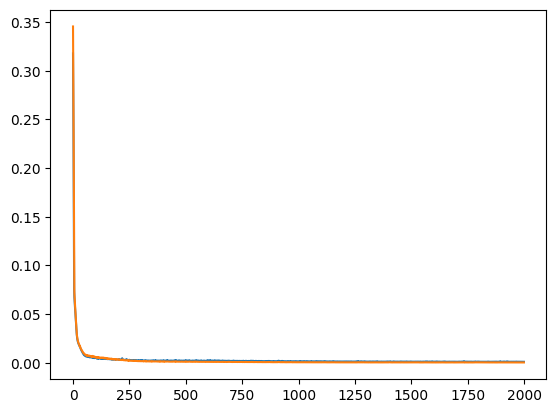

In [ ]:
print("MSE: %.5f" % best_mse)
print("RMSE: %.4f" % np.sqrt(best_mse))
plt.plot(history['test_loss'])
plt.plot(history['train_loss'])
plt.show()

Store the best weight

In [ ]:
# Store the trained MLP

torch.save(best_model_weights, new_weight_path)
torch.save(normalize_values, new_normalized_value_path)
print(f"Model weights saved! Best MSE: {best_mse}")

Model weights saved! Best MSE: 0.001071105614149322


# Optimization

Example code to run Bayesian Optimization with the trained MLP model.

## Data Process

In [ ]:
data_path = '/content/drive/My Drive/BorosilicateGlassesPotentialOptimization/data/MD_Dataset.xlsx'
new_weight_path = '/content/drive/My Drive/BorosilicateGlassesPotentialOptimization/model/BO_Model_weight.pth' #Path to the trained model weight
new_normalized_value_path = '/content/drive/My Drive/BorosilicateGlassesPotentialOptimization/model/BO_Normalized_value.pth' #path to the normalized value used for trained MLP

In [ ]:
raw_data_df = load_data(data_path)

In [ ]:
normalized_values = torch.load(new_normalized_value_path, weights_only=True)

normalized_values

{'x_min': tensor([[4.2950e+06, 1.1780e-01, 7.2645e+02, 1.0053e+04, 3.1500e-01]]),
 'x_max': tensor([[5.2494e+06, 1.3640e-01, 8.8788e+02, 1.2288e+04, 3.8500e-01]]),
 'y_min': tensor(2.1330),
 'y_max': tensor(2.6157)}

In [ ]:
#Get the Original parameter value and experimental target
original_parameter, y_target_tensor = data_process_bayes(raw_data_df)

In [ ]:
y_target_tensor[:, 0] = (y_target_tensor[:, 0] - normalized_values['y_min']) / (normalized_values['y_max'] - normalized_values['y_min'])

## Bayesian Optimization

In [ ]:
#Define the search range of Bayesian Optimization
actual_ranges, space = bayes_search_space(original_parameter, percentage_ranges)
space

[Real(low=4294985.5359, high=5249426.7661, prior='uniform', transform='identity'),
 Real(low=0.11779999999999999, high=0.13640000000000002, prior='uniform', transform='identity'),
 Real(low=726.4466901000001, high=887.8792879000001, prior='uniform', transform='identity'),
 Real(low=10053.4764312, high=12287.5823048, prior='uniform', transform='identity'),
 Real(low=0.315, high=0.385, prior='uniform', transform='identity')]

In [ ]:
actual_ranges

[(4294985.5359, 5249426.7661),
 (0.11779999999999999, 0.13640000000000002),
 (726.4466901000001, 887.8792879000001),
 (10053.4764312, 12287.5823048),
 (0.315, 0.385)]

In [ ]:
# Load the state dictionary
state_dict = torch.load(new_weight_path)

In [ ]:
#Get the trained MLP
model = create_model()
model.load_state_dict(state_dict)
model.eval()

Sequential(
  (0): Linear(in_features=6, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=16, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Move model and tensors to GPU
model = model.to(device)
y_target_tensor = y_target_tensor.to(device)

cpu


In [ ]:
#Define the Objective function

@use_named_args(space)
def objective(**params):
    parameters = [params[f'param_{i}'] for i in range(len(actual_ranges))]
    parameters = torch.tensor(parameters, dtype=torch.float32)
    norm_params = (parameters - normalized_values['x_min']) / (normalized_values['x_max'] - normalized_values['x_min'])  # Example normalization
    mse_values = []
    '''
    for i in range(len(boron_num)):
        input_tensor = torch.tensor(np.append(norm_params, boron_num[i]), dtype=torch.float32).unsqueeze(0)
        output = model(input_tensor)
        mse = torch.mean((output - y_target_tensor[i])**2).item()
        mse_values.append(mse)

    total_mse = sum(mse_values)
    '''
    boron_tensor = torch.tensor(boron_num, dtype=torch.float32).unsqueeze(1)
    norm_params_batch = norm_params.repeat(len(boron_num), 1)
    input_tensor_batch = torch.cat((norm_params_batch, boron_tensor), dim=1)

    outputs = model(input_tensor_batch)
    mse_values = torch.mean((outputs - y_target_tensor)**2, dim=1)
    total_mse = mse_values.sum().item()
    return total_mse

In [ ]:
#Run the Bayesian Optimization

callback = VerboseCallback(interval=10)
result = gp_minimize(
    objective,
    space,
    n_calls=400,  # More calls
    n_initial_points=100,  # More initial points
    acq_func='LCB',  # Change acquisition function if necessary
    #random_state=0,
    n_restarts_optimizer=10,
    verbose=False,  # Set to 0 for silent operation
    callback = [callback]
)

print(f"Best MSE: {result.fun}")
print("Best parameters:")
best_params = {f'param_{i}': result.x[i] for i in range(len(actual_ranges))}
print(best_params)

Call 10: Current Best MSE = 0.12081382423639297
Call 20: Current Best MSE = 0.12081382423639297
Call 30: Current Best MSE = 0.0436466708779335
Call 40: Current Best MSE = 0.0436466708779335
Call 50: Current Best MSE = 0.0436466708779335
Call 60: Current Best MSE = 0.0436466708779335
Call 70: Current Best MSE = 0.0436466708779335
Call 80: Current Best MSE = 0.029945582151412964
Call 90: Current Best MSE = 0.029945582151412964
Call 100: Current Best MSE = 0.029945582151412964
Call 110: Current Best MSE = 0.016190025955438614
Call 120: Current Best MSE = 0.016190025955438614
Call 130: Current Best MSE = 0.016190025955438614
Call 140: Current Best MSE = 0.016190025955438614
Call 150: Current Best MSE = 0.014933425933122635
Call 160: Current Best MSE = 0.014933425933122635
Call 170: Current Best MSE = 0.014933425933122635
Call 180: Current Best MSE = 0.014933425933122635
Call 190: Current Best MSE = 0.014933425933122635
Call 200: Current Best MSE = 0.012754052877426147
Call 210: Current Bes

The final results can be stored in any desired DataFrame format, allowing users to retrieve the top N candidate parameter sets from this Bayesian Optimization run. This process can be repeated multiple times, with the top candidate sets evaluated using MD simulations. The resulting data can then be added back into the MD dataset for the next optimization iteration.